# Model developement

## Data & Package import

In [4]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import tensorflow as tf
from dotenv import load_dotenv
load_dotenv()
from utils.gcp import load_data_from_gcs
from google.auth import credentials
from google.cloud import storage


project_root = os.path.dirname(os.getcwd())
service_account = os.path.join(project_root, 'setup', os.getenv("GCP_SERVICE_ACCOUNT"))
client = storage.Client.from_service_account_json(service_account)



bucket_name = os.getenv("GCP_BUCKET_NAME")
file_name = "data/processed/20241118-151932__data.csv"
data = load_data_from_gcs(bucket_name, file_name, client)

data["tokens"] = data["tokens"].apply(lambda x: eval(x))
data["label"] = data["label"].astype(int)

In [52]:
copy_data = data.copy()

# 1 - Data Exploration

### EDA

#### Class balance

In [47]:
# Class distribution
class_distribution = data["label"].value_counts(normalize=True)
print(class_distribution)

label
0    0.664580
1    0.212219
2    0.123201
Name: proportion, dtype: float64


#### Input Analysis

In [37]:
# Explore input length and uniqueness

# Length analysis in prepeparation for padding
data['tokens_length'] = data['tokens'].apply(lambda x: len(x))
mean_length = data['tokens_length'].mean()
quantiles_length = data['tokens_length'].quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

# Unique tokens per sample
data["unique_tokens"] = data['tokens'].apply(lambda x: len(set(x)))
mean_unique_tokens = data['unique_tokens'].mean()
quantiles_unique_tokens = data['unique_tokens'].quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])


# Vocabulary analysis
vocab_size = len(set([token for token in data['tokens'] for token in token]))


# Top most frequent tokens
token_count = {}
for row in data.tokens :
	for token in row :
		if token not in list(token_count.keys()):
			token_count[token] = 1
		else:
			token_count[token] += 1
token_count = dict(sorted(token_count.items(), key=lambda item: item[1], reverse=True))
top_tokens = dict(list(token_count.items())[:20])

In [41]:
# Shuffle data and reset_index
data = data.sample(frac=1).reset_index(drop=True)

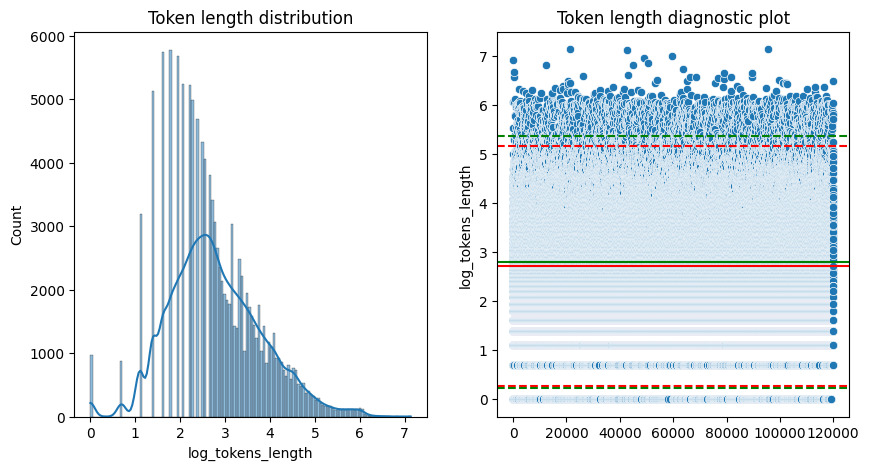

In [46]:
# Token length distribution and outlier detection
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Apply log transformation
data['log_tokens_length'] = data['tokens_length'].apply(lambda x: np.log(x+1))

# Token length distribution
sns.histplot(data['log_tokens_length'], kde=True, ax=ax[0])
ax[0].set_title("Token length distribution")

# Outlier detection
sns.scatterplot(x=list(data.index), y='log_tokens_length', data=data, ax=ax[1])
ax[1].set_title("Token length diagnostic plot")

# Outlier detection
mean = data['log_tokens_length'].mean()
median = data['log_tokens_length'].median()
std = data['log_tokens_length'].std()
mad = np.median(np.abs(data['log_tokens_length'] - median))

upper_bound = median + 2.5*(1.48*mad), mean + 2.5*std
lower_bound = median - 2.5*(1.48*mad), mean - 2.5*std

ax[1].axhline(upper_bound[0], color='r', linestyle='--')
ax[1].axhline(lower_bound[0], color='r', linestyle='--')
ax[1].axhline(upper_bound[1], color='g', linestyle='--')
ax[1].axhline(lower_bound[1], color='g', linestyle='--')
ax[1].axhline(mean, color='g', linestyle='-')
ax[1].axhline(median, color='r', linestyle='-')

plt.show();

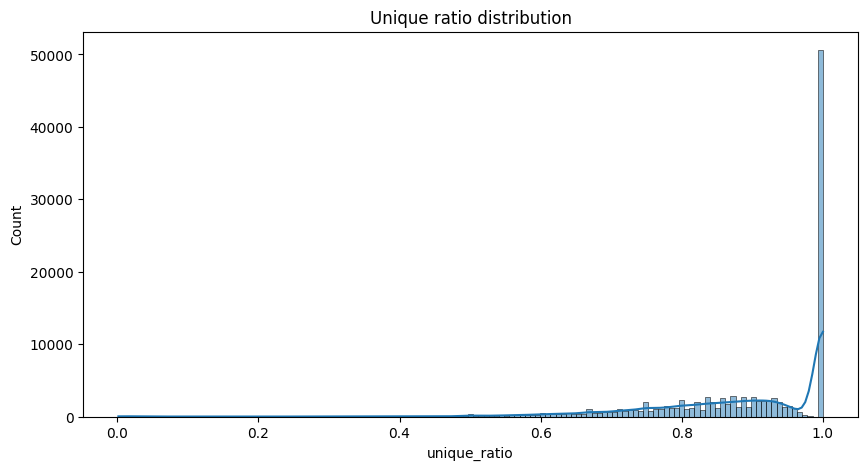

In [47]:
# Explore unique/length of tokens
data["unique_ratio"] = data['unique_tokens'] / data['tokens_length']

# Apply log transformation
epsilon = 1e-6
data['log_unique_ratio'] = data['unique_ratio']


# Unique ratio distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.histplot(data['unique_ratio'], kde=True, ax=ax)
plt.title("Unique ratio distribution")
plt.show();

#### Remove outliers

In [53]:
# Remove outliers
data = data[(data['log_tokens_length'] < upper_bound[0]) & (data['log_tokens_length'] > lower_bound[0])]

# Remove empty tokens
data = data[data['tokens_length'] > 0]

# Remove tokens with low unique ratio
data = data[data['unique_ratio'] > 0.2]

# Feature Engineering

#### Embedding

Token to index

In [62]:
# Vocabulary size and vocabulary list for embedding)
vocab = list(set([token for token in data['tokens'] for token in token]))
vocab.append("<PAD>")
vocab_size = len(vocab)
# Token to index
token_to_index = {token: idx for idx, token in enumerate(vocab)}

# Convert text tokens to index
token_to_index.get("not", token_to_index["<UNK>"])
data['tokens_index'] = data['tokens'].apply(lambda x: [token_to_index.get(token, token_to_index["<UNK>"]) for token in x])

Padding

In [63]:
# Pad sequences
from tensorflow.keras.utils import pad_sequences

max_length = data.tokens_length.max()

test = pad_sequences(data.tokens_index, maxlen=max_length, padding='post', truncating='post')
data['padded_tokens'] = [list(row) for row in test]

In [12]:
# Load the pre-trained model
from gensim.models import KeyedVectors
word2vec = KeyedVectors.load_word2vec_format(os.path.join(project_root, 'datasets/.originals/Google-News-Vectors-Negative-300.bin'), binary=True)

# Initialize the embedding matrix
embedding_dim = 300  # Word2Vec vectors are 300-dimensional
embedding_matrix = np.zeros((len(vocab), embedding_dim))

# Fill the embedding matrix with Word2Vec vectors
for i, word in enumerate(vocab):
    if word == "<PAD>":
        embedding_matrix[i] = np.zeros(embedding_dim)
    elif word == "<UNK>":
        embedding_matrix[i] = np.random.rand(embedding_dim)
    elif word in word2vec:
        embedding_matrix[i] = word2vec[word]
    else:
        embedding_matrix[i] = np.random.rand(embedding_dim)

In [9]:
embedding_matrix.shape 

(29538, 300)

# Feature Engineering Pipeline

In [ ]:
# Load data
import pandas as pd
import os
project_root = os.path.dirname(os.getcwd())
data = pd.read_pickle(os.path.join(project_root, 'datasets', 'processed', 'data.pkl'))
data.shape

(116606, 14)

Embedding

In [8]:
# Load the pre-trained model
from gensim.models import KeyedVectors
import numpy as np
import os
word2vec = KeyedVectors.load_word2vec_format(os.path.join(project_root, 'datasets/.originals/Google-News-Vectors-Negative-300.bin'), binary=True)

# Compute vocab and vocab size
vocab = set([token for token in data['tokens'] for token in token])
vocab_size = len(vocab)

# Initialize the embedding matrix
embedding_dim = 300  # Word2Vec vectors are 300-dimensional
embedding_matrix = np.zeros((len(vocab), embedding_dim))

# Fill the embedding matrix with Word2Vec vectors
for i, word in enumerate(vocab):
    if word == "<PAD>":
        embedding_matrix[i] = np.zeros(embedding_dim)
    elif word == "<UNK>":
        embedding_matrix[i] = np.random.rand(embedding_dim)
    elif word in word2vec:
        embedding_matrix[i] = word2vec[word]
    else:
        embedding_matrix[i] = np.random.rand(embedding_dim)
        
# Save the embedding matrix
project_root = os.path.dirname(os.getcwd())
np.save(os.path.join(project_root, 'datasets', 'processed', 'embedding_matrix.npy'), embedding_matrix)

In [4]:
import numpy as np
embedding_matrix = np.load(os.path.join(project_root, 'datasets', 'processed', 'embedding_matrix.npy'))

Dataset preparation

In [42]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Data
X = data['padded_tokens']
y = data['label']

# One-hot encode the labels
y = to_categorical(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# To tensors
X_train = tf.ragged.constant(X_train, dtype=tf.int32)
X_train = X_train.to_tensor(default_value=0)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)

X_test = tf.ragged.constant(X_test, dtype=tf.int32)
X_test = X_test.to_tensor(default_value=0)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)


# Batch
batch_size = 32
train_data = tf.data.Dataset.from_tensor_slices(
    {
        'features': X_train, 
        'labels': y_train
    }
).batch(batch_size)

test_data = tf.data.Dataset.from_tensor_slices(
    {
        'features': X_test, 
        'labels': y_test
    }
).batch(batch_size)

# Model Initialization

In [48]:
class_distribution

label
0    0.664580
1    0.212219
2    0.123201
Name: proportion, dtype: float64

In [34]:
import tensorflow as tf

# Define baseline model
class BaselineModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_matrix, max_length):
        super(BaselineModel, self).__init__()
        self.embedding_layer = tf.keras.layers.Embedding(
                        input_dim=embedding_matrix.shape[0],
                        output_dim=embedding_matrix.shape[1],
                        weights=[embedding_matrix],
                        trainable=False)
        self.lstm_layer = tf.keras.layers.LSTM(units=16)
        self.output_layer = tf.keras.layers.Dense(2, activation='softmax')
        
    def call(self, x):
        x = self.embedding_layer(x)
        x = self.lstm_layer(x)
        x = self.output_layer(x)
        return x
    

    


<_BatchDataset element_spec=(TensorSpec(shape=(None, 170), dtype=tf.int32, name=None), TensorSpec(shape=(None, 3), dtype=tf.int32, name=None))>

14.333628695345622

# Model Training & Evaluation

# Model testing

# Baseline Model with one layer

In [5]:
import tensorflow as tf

# Check if GPUs are available
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Available GPUs:", gpus)


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
# Transform data to tensorflow dataset
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Model data
X = data['padded_tokens'].values
y = data['label'].values

y_one_hot = to_categorical(y)

In [10]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Convert to tensors
train_features_ragged = tf.ragged.constant(X_train, dtype=tf.int32)
train_features_tensor = train_features_ragged.to_tensor(default_value=0)
train_labels_tensor = tf.convert_to_tensor(y_train, dtype=tf.int32)

test_features_ragged = tf.ragged.constant(X_test, dtype=tf.int32)
test_features_tensor = test_features_ragged.to_tensor(default_value=0)
test_labels_tensor = tf.convert_to_tensor(y_test, dtype=tf.int32)

train_dataset = tf.data.Dataset.from_tensor_slices((train_features_tensor, train_labels_tensor)) # Create a tf.data.Dataset object
test_dataset = tf.data.Dataset.from_tensor_slices((test_features_tensor, test_labels_tensor))

# batch the dataset
batch_size = 512
batched_dataset = train_dataset.batch(batch_size)
batched_evaluation = test_dataset.batch(batch_size)

In [19]:
# Define custom metrics
class PrecisionMulticlass(tf.keras.metrics.Metric):
    def __init__(self, name='precision', n_class=3, **kwargs):
        super(PrecisionMulticlass, self).__init__(name=name, **kwargs)
        self.precision = self.add_weight(
            shape=(n_class,),
            name='precision',
            initializer='zeros')
        self.n_class = n_class
        self.true_positives = self.add_weight(name='true_positives', shape=(self.n_class,), initializer='zeros')
        self.false_positives = self.add_weight(name='false_positives', shape=(self.n_class,), initializer='zeros')
        
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.int64)
        y_pred = tf.cast(tf.one_hot(tf.argmax(y_pred, axis=1), self.n_class), tf.int64)
        
        for i in range(self.n_class):
            true_positive = tf.reduce_sum(y_true[:, i] * y_pred[:, i])
            false_positive = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true[:, i], 0), tf.equal(y_pred[:, i], 1)), tf.int64))
            
            index = [[i]]  # Index for the class we are updating
            self.true_positives.assign(tf.tensor_scatter_nd_add(self.true_positives, index, [true_positive]))
            self.false_positives.assign(tf.tensor_scatter_nd_add(self.false_positives, index, [false_positive]))
            
    def result(self):
        precision_per_class = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        return tf.reduce_mean(precision_per_class)
    
    def reset_states(self):
        self.true_positives.assign(tf.zeros(self.n_class))
        self.false_positives.assign(tf.zeros(self.n_class))
        
        

class RecallMulticlass(tf.keras.metrics.Metric):
    def __init__(self, name='recall', n_class=3, **kwargs):
        super(RecallMulticlass, self).__init__(name=name, **kwargs)
        self.recall = self.add_weight(
            shape=(n_class,),
            name='recall',
            initializer='zeros')
        self.n_class = n_class
        self.true_positives = self.add_weight(name='true_positives', shape=(self.n_class,), initializer='zeros')
        self.false_negatives = self.add_weight(name='false_negatives', shape=(self.n_class,), initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.int64)
        y_pred = tf.cast(tf.one_hot(tf.argmax(y_pred, axis=1), self.n_class), tf.int64)
        
        for i in range(self.n_class):
            true_positive = tf.reduce_sum(y_true[:, i] * y_pred[:, i])
            false_negative = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true[:, i], 1), tf.equal(y_pred[:, i], 0)), tf.int64))
            
            index = [[i]]  # Index for the class we are updating
            self.true_positives.assign(tf.tensor_scatter_nd_add(self.true_positives, index, [true_positive]))
            self.false_negatives.assign(tf.tensor_scatter_nd_add(self.false_negatives, index, [false_negative]))
            
    def result(self):
        recall_per_class = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        return tf.reduce_mean(recall_per_class)
    
    def reset_states(self):
        self.true_positives.assign(tf.zeros(self.n_class))
        self.false_negatives.assign(tf.zeros(self.n_class))
            
    
        

In [15]:

# Define custom weighted loss
class_distribution = data['label'].value_counts(normalize=True)
weights = (1/class_distribution) # Weight
weights = weights / weights.sum() # Normalize

# Define custom loss
class WeightedCategoricalCrossEntropy(tf.keras.losses.Loss):
    def __init__(self, weights, name='weighted_categorical_crossentropy', **kwargs):
        super(WeightedCategoricalCrossEntropy, self).__init__()
        self.weights = tf.cast(weights, tf.float32)
        
    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        # Clip y_pred to avoid log(0)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        weighted_losses = -self.weights * y_true * tf.math.log(y_pred)
        return tf.reduce_mean(tf.reduce_sum(weighted_losses, axis=1))

In [27]:
from tensorflow.keras.callbacks import TensorBoard
import os

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',     
    patience=5,             
    mode='min',            
    min_delta=0.001,        
    restore_best_weights=True
)

# TensorBoard
log_dir = os.path.join(project_root, "logs", "fit")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Params
vocab = list(set([token for token in data['tokens'] for token in token]))
vocab_size = len(vocab)
embedding_dim = 300


# Metrics
metrics = [
      RecallMulticlass(name='recall', n_class=train_dataset.element_spec[1].shape[0]),
      PrecisionMulticlass(name='precision', n_class=train_dataset.element_spec[1].shape[0])
      ]

# Embedding layer
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False,
    name='embedding'
)

# Model
baseline_model = Sequential([
    embedding_layer,
    LSTM(units=64, name="lstm1"),
    Dense(units=64, activation='relu', name='dense1'),
    Dense(units=3, activation='softmax', name='output')
], name='baseline_model')


baseline_model.compile(optimizer='adam', loss=WeightedCategoricalCrossEntropy(weights=weights),
                       metrics=metrics)

baseline_model.summary()

# train the model
baseline_model_history = baseline_model.fit(batched_dataset, epochs=10, callbacks=[early_stopping, tensorboard_callback],
                                            validation_data=batched_evaluation)

# Evaluate the model
#baseline_model.evaluate(batched_evaluation)

Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         8861400   
                                                                 
 lstm1 (LSTM)                (None, 64)                93440     
                                                                 
 dense1 (Dense)              (None, 64)                4160      
                                                                 
 output (Dense)              (None, 3)                 195       
                                                                 
Total params: 8959195 (34.18 MB)
Trainable params: 97795 (382.01 KB)
Non-trainable params: 8861400 (33.80 MB)
_________________________________________________________________
Epoch 1/10
183/183 [==============================] - ETA: 0s - loss: 0.2305 - recall: 0.3320 - precision: 0.3330

/Users/theopinto--dalle/code/arewetoxic/env/lib/python3.10/site-packages/keras/src/engine/training.py:2699: UserWarning: Metric RecallMulticlass implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
/Users/theopinto--dalle/code/arewetoxic/env/lib/python3.10/site-packages/keras/src/engine/training.py:2699: UserWarning: Metric PrecisionMulticlass implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


183/183 [==============================] - 26s 130ms/step - loss: 0.2305 - recall: 0.3320 - precision: 0.3330 - val_loss: 0.2300 - val_recall: 0.3338 - val_precision: 0.3883
Epoch 2/10
183/183 [==============================] - 21s 112ms/step - loss: 0.2301 - recall: 0.3329 - precision: 0.3337 - val_loss: 0.2299 - val_recall: 0.3344 - val_precision: 0.3833
Epoch 3/10
183/183 [==============================] - 20s 108ms/step - loss: 0.2303 - recall: 0.3334 - precision: 0.3344 - val_loss: 0.2296 - val_recall: 0.3367 - val_precision: 0.3822
Epoch 4/10
183/183 [==============================] - 20s 107ms/step - loss: 0.2128 - recall: 0.4596 - precision: 0.4434 - val_loss: 0.1837 - val_recall: 0.6016 - val_precision: 0.5744
Epoch 5/10
183/183 [==============================] - 25s 136ms/step - loss: 0.1603 - recall: 0.6681 - precision: 0.6525 - val_loss: 0.1426 - val_recall: 0.7179 - val_precision: 0.7075
Epoch 6/10
183/183 [==============================] - 21s 112ms/step - loss: 0.1494 - 

In [20]:
# Evaluate the model
test_metrics = baseline_model.evaluate(batched_evaluation)
print(f"Test metrics: {test_metrics}")

 1/46 [..............................] - ETA: 7s - loss: 0.1247 - recall: 0.7967 - precision: 0.7806

/Users/theopinto--dalle/code/arewetoxic/env/lib/python3.10/site-packages/keras/src/engine/training.py:2699: UserWarning: Metric RecallMulticlass implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
/Users/theopinto--dalle/code/arewetoxic/env/lib/python3.10/site-packages/keras/src/engine/training.py:2699: UserWarning: Metric PrecisionMulticlass implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


46/46 [==============================] - 2s 41ms/step - loss: 0.1247 - recall: 0.7781 - precision: 0.7639
Test metrics: [0.12471047043800354, 0.778072714805603, 0.7638833522796631]


In [24]:
baseline_model.save(os.path.join(project_root, 'saved_models', 'baseline_model'))

INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/saved_models/baseline_model/assets


INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/saved_models/baseline_model/assets


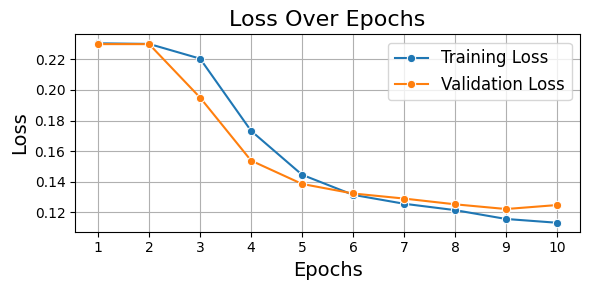

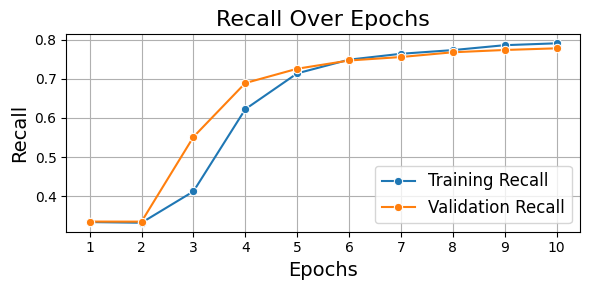

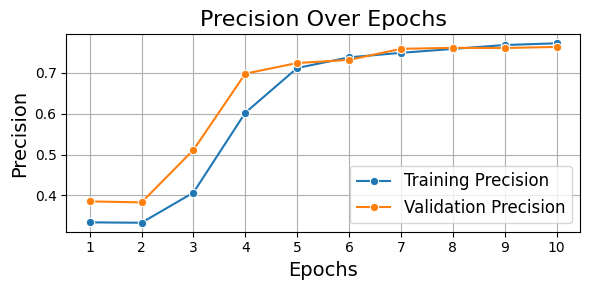

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_metrics_with_seaborn(history):

    # Extract metrics from history
    metrics = [key for key in history.history.keys() if 'val_' not in key]
    epochs = range(1, len(history.history[metrics[0]]) + 1)
    

    for metric in metrics:
        plt.figure(figsize=(6, 3))
        
        # Plot training metric
        sns.lineplot(x=epochs, y=history.history[metric], label=f'Training {metric.capitalize()}', marker='o')
        
        # Plot validation metric if available
        if f'val_{metric}' in history.history:
            sns.lineplot(x=epochs, y=history.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}', marker='o')
        
        # Formatting
        plt.title(f'{metric.capitalize()} Over Epochs', fontsize=16)
        plt.xlabel('Epochs', fontsize=14)
        plt.ylabel(metric.capitalize(), fontsize=14)
        plt.legend(loc='best', fontsize=12)
        plt.grid(True)
        plt.xticks(epochs)  # Show each epoch number on x-axis
        plt.tight_layout()  # Adjust layout for better fit
        plt.show()

plot_metrics_with_seaborn(baseline_model_history)
